<a href="https://colab.research.google.com/github/TheOnesThatWereAbroad/Assignment1/blob/main/POS_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - POS tagging

In [ ]:
!git clone https://c9699cfe58c4d4109c1407f6ac2a52494cff8d40@github.com/TheOnesThatWereAbroad/Assignment1.git
%cd Assignment1
!pip install keras-tuner tensorflow-addons

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from urllib import request
import zipfile

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.models import model_from_json
import keras_tuner as kt
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report


## 1. Build a dataset

### 1.1 Dataset preparation
For this experiment, the [Dependency Parsed Treebank](https://www.nltk.org/nltk_data/) dataset is used.
Notice that each document is splitted into sentences, so the dimensionality of the data is more than 199 (total number of documents in the dataset)

In [2]:
class DataInput:
    """
    This class is used to load the data from the data_url and create the train, dev and test datasets.
    """

    def __init__(
        self,
        data_url,
        train_size,
        dev_size,
        dataset_folder="data",
        split_into_sentences=True,
        shuffle=False,
    ):
        """
        Constructor for DataInput class that loads the data from the data_url and creates the train, dev and test datasets.
        The dataset splitted is available through the instance variables self.train, self.dev, self.test

        Parameters
        ----------
        data_url : URL of the dataset
        train_size : percentage of the dataset that will be used for training
        dev_size : percentage of the dataset that will be used for development
        dataset_folder : folder where the dataset will be downloaded
        split_into_sentences : boolean indicating if each document in the dataset should be splitted into sentences or not
        shuffle : boolean indicating if the dataset should be shuffled or not before splitting
        """
        docs = self.import_data(data_url, dataset_folder)
        X, y = self.parse_dataset(docs, split_into_sentences)
        self.max_size = self.get_max_size(X)
        self.train, self.dev, self.test = self.train_dev_test_split(
            X,
            y,
            train_size,
            dev_size,
            path_store=os.path.join(dataset_folder, "split"),
            shuffle=shuffle,
        )

    def import_data(self, data_url, dataset_folder):
        """
        Import dataset from URL.

        Parameters
        ----------
        data_url : URL of the dataset
        dataset_folder : folder where the dataset will be downloaded

        Returns
        -------
        list of document paths
        """
        # create dataset folder if it does not exist
        if not os.path.exists(dataset_folder):
            os.makedirs(dataset_folder)

        # extract the dataset if it is not extracted
        if not glob.glob(os.path.join(dataset_folder, "**/*.dp"), recursive=True):

            # download the dataset if it does not exist
            dataset_zip = os.path.join(dataset_folder, data_url.split("/")[-1])
            if not os.path.exists(dataset_zip):
                print("Downloading the dataset...")
                request.urlretrieve(data_url, dataset_zip)
                print("Successful download!")

            # extract the dataset
            print("Extracting the dataset...")
            with zipfile.ZipFile(dataset_zip, "r") as zip_ref:
                zip_ref.extractall(dataset_folder)
                print("Successfully extracted the dataset!")
            os.remove(dataset_zip)

        dataset_extracted_dir = os.path.join(
            dataset_folder, os.listdir(dataset_folder)[0]
        )
        docs = [
            os.path.join(dataset_extracted_dir, doc)
            for doc in sorted(os.listdir(dataset_extracted_dir))
        ]
        return docs

    def parse_dataset(self, docs, split_into_sentences):
        """
        Parse the dependency treebank dataset. This takes into account if the dataset should be splitted into sentences or not (according to self.split_into_sentences).

        Parameters
        ----------
        docs : list of document paths
        split_into_sentences : boolean indicating if each document in the dataset should be splitted into sentences or not

        Returns
        -------
        pair where the first element is a list of lists representing tokens in each document/sentence, the second is a list of lists representing POS tag of tokens in each document/sentence
        """
        X = []
        y = []
        for doc in docs:
            if split_into_sentences:
                # if split_into_sentences is True, then we split the document into sentences considering as new sentence all the tokens after an empty line in the document
                with open(doc, mode="r", encoding="utf-8") as text_file:
                    sentence_text = []
                    sentence_tags = []

                    # read the doc and extract informations
                    for line in text_file.readlines():
                        if line.strip() == "":
                            # if the line is empty, then we add the sentence to the list of sentences
                            X.append(np.array(sentence_text))
                            y.append(np.array(sentence_tags))
                            sentence_text = []
                            sentence_tags = []
                        else:
                            # if the line is not empty, then we add the token to the sentence
                            token, tag, number = line.split("\t")
                            sentence_text.append(token)
                            sentence_tags.append(tag)
                    X.append(np.array(sentence_text))
                    y.append(np.array(sentence_tags))
            else:
                # otherwise we consider the whole document as a single data point
                np_doc = np.loadtxt(doc, str, delimiter="\t", usecols=(0, 1))
                X.append(np_doc[:, 0])
                y.append(np_doc[:, 1])
        return np.array(X, dtype=object), np.array(y, dtype=object)

    def get_max_size(self, X):
        """
        Get the maximum size of the dataset.

        Parameters
        ----------
        X : list of lists of tokens

        Returns
        -------
        int
        """
        return max([len(x) for x in X])

    def train_dev_test_split(
        self, X, y, train_size, dev_size, path_store=None, shuffle=False
    ):
        """
        Split dataset into train, validation and test.

        Parameters
        ----------
        X : list of lists of tokens in each document/sentence
        y : list of lists of POS tags in each document/sentence
        train_size : percentage of the dataset used for training
        dev_size : percentage of the dataset used for validation (note that test size is 1-train_size-dev_size)
        shuffle : boolean indicating if the dataset should be shuffled before splitting
        path_store : path where the split datasets will be stored. If None, then the split datasets will not be stored.

        Returns
        -------
        triple where the first element is the train-set, the second element is the dev-set and the third element is the test-set
        """
        # shuffle the dataset
        if shuffle:
            dataset = list(zip(X, y))
            random.shuffle(dataset)
            X, y = zip(*dataset)
            X, y = np.array(X), np.array(y)

        # create folder where the split datasets will be stored if it does not exist
        if path_store is not None and not os.path.exists(path_store):
            os.makedirs(os.path.join(path_store, "train"))
            os.makedirs(os.path.join(path_store, "dev"))
            os.makedirs(os.path.join(path_store, "test"))

        # build the train set
        train_size = int(np.ceil(train_size * len(X)))
        train_set = (X[:train_size], y[:train_size])
        if path_store is not None:
            np.savetxt(
                os.path.join(path_store, "train", "X_train.txt"), train_set[0], fmt="%s"
            )
            np.savetxt(
                os.path.join(path_store, "train", "y_train.txt"), train_set[1], fmt="%s"
            )
        print("Train set size:", len(train_set[0]))

        # build the dev set
        dev_size = int(np.ceil(dev_size * len(X)))
        dev_set = (
            X[train_size : train_size + dev_size],
            y[train_size : train_size + dev_size],
        )
        if path_store is not None:
            np.savetxt(
                os.path.join(path_store, "dev", "X_dev.txt"), dev_set[0], fmt="%s"
            )
            np.savetxt(
                os.path.join(path_store, "dev", "y_dev.txt"), dev_set[1], fmt="%s"
            )
        print("Dev set size:", len(dev_set[0]))

        # build the test set
        test_set = (X[train_size + dev_size :], y[train_size + dev_size :])
        if path_store is not None:
            np.savetxt(
                os.path.join(path_store, "test", "X_test.txt"), test_set[0], fmt="%s"
            )
            np.savetxt(
                os.path.join(path_store, "test", "y_test.txt"), test_set[1], fmt="%s"
            )
        print("Test set size:", len(test_set[0]))
        return train_set, dev_set, test_set

    def preprocessing(self, set="train", to_lower=True):
        """
        Preprocess the dataset.

        Parameters
        ----------
        set : the set to preprocess (it can be train, dev or test)
        to_lower : boolean indicating if the dataset should be converted to lowercase
        """
        # lower the tokens in a given set
        if set == "train" or set == "dev" or set == "test":
            for doc in getattr(self, set)[0]:
                if to_lower:
                    for i in range(len(doc)):
                        doc[i] = doc[i].lower()
        else:
            raise ValueError("Invalid set name. It should be train, dev or test.")


In [3]:
# download the dataset and split it into train, dev and test sets
dataset = DataInput(
        data_url="https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip",
        train_size=0.50,
        dev_size=0.25,
        dataset_folder=os.path.join(os.getcwd(), "dataset"),
        split_into_sentences=True,
        shuffle=False
    )

Train set size: 1957
Dev set size: 979
Test set size: 978


Pre-processing is always an important step with which start. There are a lot of pre-processing steps that we can consider, but for this experiment the only pre-processing operation performed is:
- **to lower**, in part-of-speech tagging scenario casing of the input tokens is crucial to find the correspondent token in the embedding vocabulary

In [4]:
# do preprocessing for train, validation and test sets
dataset.preprocessing("train", to_lower=True)
dataset.preprocessing("dev", to_lower=True)
dataset.preprocessing("test", to_lower=True)

# separate inputs and targets
X_train, y_train = dataset.train
X_dev, y_dev = dataset.dev
X_test, y_test = dataset.test

In [5]:
X_test_sentences = X_test
print("Example of input document: ", ' '.join(X_test_sentences[1]))
print("Training set shape: ", X_train.shape)

Example of input document:  too often now , a single court decision becomes the precedent for other , less compelling cases .
Training set shape:  (1957,)


### 1.2 Dataset analysis
Let's take a look at the dataset, to inspect the distribution of the POS tags

In [6]:
def get_occurences(data, ordered=False, exclude=[]):
    """
    Get the occurences of each token in the data.

    Parameters
    ----------
    data : list of np arrays, representing the data to get the occurences from
    ordered : bool, if True, the occurences will be returned in descending order
    exclude : list of strings, tokens that should not be included in the occurences

    Returns
    -------
    occurences : dict, mapping each token to the number of occurences
    """
    tokens, counts = np.unique(np.concatenate(data), return_counts=True)
    occurences = dict(zip(tokens, counts))

    if len(exclude) > 0:
        for token in exclude:
            if token in occurences:
                del occurences[token]

    if ordered:
        occurences = dict(sorted(occurences.items(), key=lambda x: x[1], reverse=True))
    return occurences

# get the occurences of each POS tag in the three sets 
train_tags_occ = get_occurences(y_train, ordered=True, exclude=[])
dev_tags_occ = get_occurences(y_dev, exclude=[])
test_tags_occ = get_occurences(y_test, exclude=[])

# build a matrix of the occurences of size (n_tags, 3)
tags_occ = np.array([[v, dev_tags_occ[k], test_tags_occ[k]] if k in dev_tags_occ and k in test_tags_occ else [v, dev_tags_occ[k], 0] if k in dev_tags_occ else [v, 0, test_tags_occ[k]] if k in test_tags_occ else [v, 0, 0] for k, v in train_tags_occ.items()])

[]

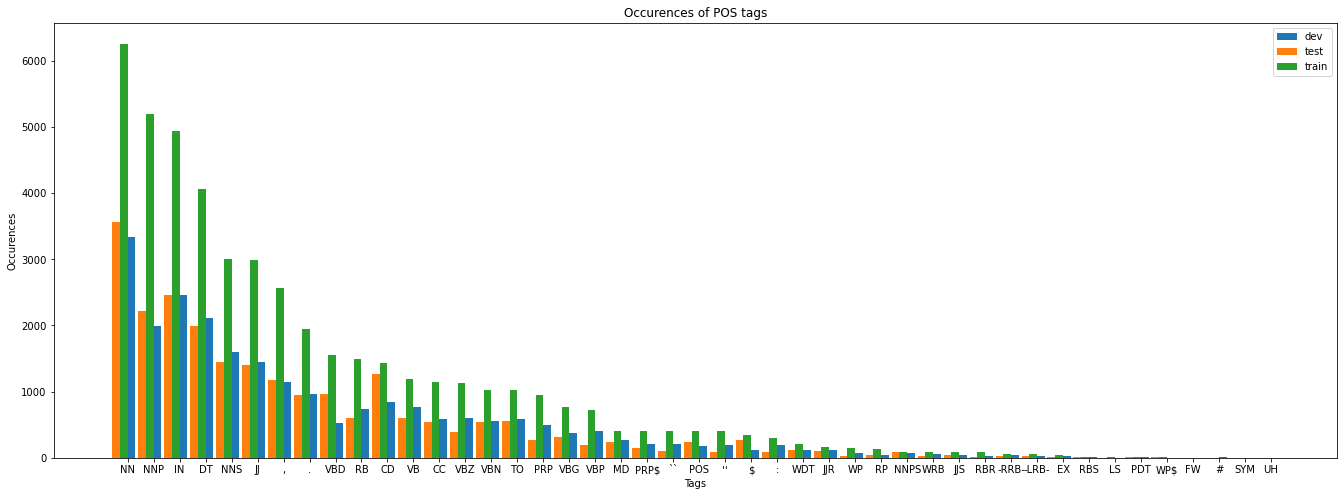

In [7]:
# plot bar chart of the occurences of each POS tag
fig, ax = plt.subplots(1, 1, figsize=(23, 8))
tags = list(train_tags_occ.keys())
ax.bar(tags, tags_occ[:, 1], width=0.3, align='edge', label='dev')
ax.bar(tags, tags_occ[:, 2], width=-0.6, align='edge', label='test')
ax.bar(tags, tags_occ[:, 0], width=-0.3, align='edge', label='train')
ax.set_xticks(tags)
ax.set_xlabel('Tags')
ax.set_ylabel('Occurences')
ax.set_title("Occurences of POS tags")
ax.legend()
plt.plot()

In [8]:
# analyze the difference between the presence of the POS tags in the train, dev and test sets
train_tags_not_dev = set(train_tags_occ.keys()) - set(dev_tags_occ.keys())
train_tags_not_test = set(train_tags_occ.keys()) - set(test_tags_occ.keys())
dev_tags_not_train = set(dev_tags_occ.keys()) - set(train_tags_occ.keys())
test_tags_not_train = set(test_tags_occ.keys()) - set(train_tags_occ.keys())

if(len(train_tags_not_dev) > 0):
    print("The following tags (from the train set) are not in the dev set:", train_tags_not_dev)
if(len(train_tags_not_test) > 0):
    print("The following tags (from the train set) are not in the test set:", train_tags_not_test)
if(len(dev_tags_not_train) > 0):
    print("The following tags (from the dev set) are not in the train set:", dev_tags_not_train)
if(len(test_tags_not_train) > 0):
    print("The following tags (from the test set) are not in the train set:", test_tags_not_train)

The following tags (from the train set) are not in the dev set: {'SYM'}
The following tags (from the train set) are not in the test set: {'UH', 'FW', 'SYM', 'LS'}


### 1.3 GloVe embeddings vectorization
The next step consists in downloading a pre-trained embedding model, namely GloVe. It is a techniques that tries to encoded global semantic properties based on the co-occurrence matrix.
Three different dimensional space versions are available: 50, 100, 200. In this experiment the version with vectors of length 100 is used.

From the choosen embedding, a starting vocabulary is built.
Then this vocabulary is enriched with the embeddings computed for the OOV words.

In [9]:
class NotAdaptedError(Exception):
    pass


class TextVectorizer:
    def __init__(
        self,
        glove_url="http://nlp.stanford.edu/data/glove.6B.zip",
        embedding_dim=100,
        embedding_folder="glove",
        max_size=300,
    ):
        """
        This class parses the GloVe embeddings, the input documents are expected
        to be in the form of a list of lists.
        [["word1", "word2", ...], ["word1", "word2", ...], ...]

        Parameters
        ----------
        glove_url : The url of the GloVe embeddings.
        embedding_dim : The dimension of the embeddings (pick one of 50, 100, 200, 300).
        embedding_folder : folder where the embedding will be downloaded
        max_size : The maximum size of the documents.
        """
        self.embedding_dim = embedding_dim
        self.download_glove_if_needed(
            glove_url=glove_url, embedding_folder=embedding_folder
        )
        self.max_size = max_size

        # create the vocabulary
        self.vocabulary = self.parse_glove(embedding_folder)

    def download_glove_if_needed(self, glove_url, embedding_folder):
        """
        Downloads the glove embeddings from the internet

        Parameters
        ----------
        glove_url : The url of the GloVe embeddings.
        embedding_folder: folder where the embedding will be downloaded
        """
        # create embedding folder if it does not exist
        if not os.path.exists(embedding_folder):
            os.makedirs(embedding_folder)

        # extract the embedding if it is not extracted
        if not glob.glob(
            os.path.join(embedding_folder, "**/glove*.txt"), recursive=True
        ):

            # download the embedding if it does not exist
            embedding_zip = os.path.join(embedding_folder, glove_url.split("/")[-1])
            if not os.path.exists(embedding_zip):
                print("Downloading the GloVe embeddings...")
                request.urlretrieve(glove_url, embedding_zip)
                print("Successful download!")

            # extract the embedding
            print("Extracting the embeddings...")
            with zipfile.ZipFile(embedding_zip, "r") as zip_ref:
                zip_ref.extractall(embedding_folder)
                print("Successfully extracted the embeddings!")
            os.remove(embedding_zip)

    def parse_glove(self, embedding_folder):
        """
        Parses the GloVe embeddings from their files, filling the vocabulary.

        Parameters
        ----------
        embedding_folder : folder where the embedding files are stored

        Returns
        -------
        dictionary representing the vocabulary from the embeddings
        """
        vocabulary = {"<pad>": np.zeros(self.embedding_dim)}
        embedding_file = os.path.join(
            embedding_folder, "glove.6B." + str(self.embedding_dim) + "d.txt"
        )
        with open(embedding_file, encoding="utf8") as f:
            for line in f:
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                vocabulary[word] = coefs
        return vocabulary

    def adapt(self, documents):
        """
        Computes the OOV words for a single data split, and adds them to the vocabulary.

        Parameters
        ----------
        documents : The data split (might be training set, validation set, or test set).
        """
        # create a set containing words from the documents in a given data split
        words = {word for doc in documents for word in doc}
        oov_words = words - self.vocabulary.keys()

        # add the OOV words to the vocabulary giving them a random encoding
        for word in oov_words:
            self.vocabulary[word] = np.random.uniform(-1, 1, size=self.embedding_dim)
        print(f"Generated embeddings for {len(oov_words)} OOV words.")

    def transform(self, documents):
        """
        Transform the data into the input structure for the training. This method should be used always after the adapt method.

        Parameters
        ----------
        documents : The data split (might be training set, validation set, or test set).

        Returns
        -------
        Array of shape (number of documents, number of words, embedding dimension)
        """
        result = []
        for document in documents:
            result.append(
                np.vstack(
                    (
                        self._transform_document(document),
                        np.zeros((self.max_size - len(document), self.embedding_dim)),
                    )
                )
            )
        return np.array(result)

    def _transform_document(self, document):
        """
        Transforms a single document to the GloVe embedding

        Parameters
        ----------
        document : The document to be transformed.

        Returns
        -------
        Numpy array of shape (number of words, embedding dimension)
        """
        try:
            return np.array([self.vocabulary[word] for word in document])
        except KeyError:
            raise NotAdaptedError(
                f"The whole document is not in the vocabulary. Please adapt the vocabulary first."
            )

In [10]:
# initialize the vectorizer for the input tokens to convert them to embedding vectors
# and build the vocabulary V1 from the glove embeddings
text_vectorizer = TextVectorizer(
    glove_url="http://nlp.stanford.edu/data/glove.6B.zip",
    embedding_dim=100,
    embedding_folder=os.path.join(os.getcwd(), "glove"),
    max_size=dataset.max_size
)

# compute embeddings for terms (OOV1) in the training set that are out of vocabulary V1 and add them: V2=V1+OOV1
print("Parsing the training set...")
text_vectorizer.adapt(X_train)
# use the vocabulary V2 to convert the training set inputs into embedding vectors
X_train = text_vectorizer.transform(X_train)

# compute embeddings for terms (OOV2) in the validation set that are out of vocabulary V2 and add them: V3=V2+OOV2
print("\nParsing the validation set...")
text_vectorizer.adapt(X_dev)
# use the vocabulary V3 to convert the validation set inputs into embedding vectors
X_dev = text_vectorizer.transform(X_dev)

# compute embeddings for terms (OOV3) in the test set that are out of vocabulary V3 and add them: V4=V3+OOV3
print("\nParsing the test set...")
text_vectorizer.adapt(X_test)
# use the vocabulary V4 to convert the test set inputs into embedding vectors
X_test = text_vectorizer.transform(X_test)

Parsing the training set...
Generated embeddings for 358 OOV words.

Parsing the validation set...
Generated embeddings for 131 OOV words.

Parsing the test set...
Generated embeddings for 187 OOV words.


In [11]:
print(f"Input shape: {X_train.shape}")

Input shape: (1957, 249, 100)


### 1.4 One-hot encoding of the targets
Each POS tag in each set is converted using the one-hot representation

In [12]:
class TargetVectorizer:
    def __init__(self, max_size):
        """
        This class one-hot encodes the target documents, containing the POS tags.
        """
        self.vectorizer = LabelBinarizer()
        self.max_size = max_size

    def adapt(self, targets):
        """
        Fits the vectorizer for the classes.

        Parameters
        ----------
        targets : The target tags for the dataset split given (it is a list of lists).
        """
        self.vectorizer.fit(
            [target for doc_targets in targets for target in doc_targets]
        )

    def transform(self, targets):
        """
        Performs the one-hot encoding for the dataset Ys, returning a list of encoded document tags.

        Parameters
        ----------
        targets : The target tags for the dataset split given (it is a list of lists).

        Returns
        -------
        List of shape (number of documents, numbero of tokens, number of classes)
        """
        if self.vectorizer.classes_.shape[0] == 0:
            raise NotAdaptedError(
                "The target vectorizer has not been adapted yet. Please adapt it first."
            )

        result = []
        for document in targets:
            transformed = self.vectorizer.transform(document)
            pad_size = (self.max_size - len(document), transformed.shape[1])
            result.append(
                np.vstack((self.vectorizer.transform(document), np.zeros(pad_size)))
            )
        return np.array(result)

    def inverse_transform(self, targets):
        """
        Performs the inverse one-hot encoding for the dataset Ys, returning a list of decoded document tags.
        Parameters
        ----------
        targets : The target tags for the dataset split given, already in one-hot encoding form.
        Returns
        -------
        List of decoded document tags
        """
        if self.vectorizer.classes_.shape[0] == 0:
            raise NotAdaptedError(
                "The target vectorizer has not been adapted yet. Please adapt it first."
            )
        return np.array(
            [
                self.vectorizer.inverse_transform(document[document.any(1)])
                for document in targets
            ]
            , dtype=object
        )

    def inverse_transform_probabilities(self, targets):
        """
        Performs the inverse one-hot encoding for a prediction, given the matrix of probabilities.

        Parameters
        ----------
        targets : The predicted probabilities for targets.

        Returns
        -------
        List of decoded document tags
        """
        n_classes = targets.shape[2]
        targets = np.array(
            [document[np.std(document, axis=1) > 0.05] for document in targets], dtype=object
        )
        y_pred = np.zeros((len(targets), max([len(document) for document in targets]), n_classes))
        for i, document in enumerate(targets):
            for j, word in enumerate(document):
                y_pred[i, j, np.argmax(word)] = 1

        return self.inverse_transform(y_pred)

    def get_classes(self):
        """
        Returns the classes of the target vectorizer.

        Returns
        -------
        List of classes
        """
        return self.vectorizer.classes_

In [13]:
# initialize the vectorizer for the target tags to convert them into one-hot representation
target_vectorizer = TargetVectorizer(max_size=dataset.max_size)

# adapt the target vectorizer with only the training set: we do not consider possible targets that are not seen in training set but they are in the dev/test set
target_vectorizer.adapt(y_train)  

# convert the targets into one-hot representation for each splitting set
y_train = target_vectorizer.transform(y_train)
y_dev = target_vectorizer.transform(y_dev)
y_test = target_vectorizer.transform(y_test)

n_classes = y_train[0].shape[1]

In [14]:
print(f"Target shape: {y_train.shape}")
print(f"Number of classes for one-hot encoded targets: {n_classes}")

Target shape: (1957, 249, 45)
Number of classes for one-hot encoded targets: 45


## 2. Training

### 2.1 Models definition
We are now ready to define our neural network architectures! 
Four variants will be evaluated:
- Bidirectional LSMT + Dense layer
- Bidirectional GRU + Dense layer
- Two Bidirectional LSMT + Dense layer
- Bidirectional LSMT + Two Dense layer

In [15]:
tfa_f1 = tfa.metrics.F1Score(
    num_classes= n_classes,
    name = 'f1_score',
    )
punctuation_indices = [0, 1, 2, 3, 4, 5, 6,7, 16, 30, 43]

def f1_with_tfa(y_true, y_pred):
    """
    Computes the F1 score using TensorFlow.
    The punctuation is ignored.
    """
    y_true = tf.reshape(y_true, (-1, n_classes))
    punctuation = tf.gather(y_true, punctuation_indices, axis=-1)
    y_mask = tf.cast(tf.logical_not(tf.reduce_any(tf.cast(punctuation, tf.bool), axis=-1)), tf.float32)
    y_pred = tf.reshape(y_pred, (-1, n_classes))
    tfa_f1.update_state(y_true, y_pred, sample_weight=y_mask)
    result = tfa_f1.result()
    K.batch_set_value([(v, np.zeros(v.shape.as_list())) for v in tfa_f1.variables])
    return K.sum(result)/(n_classes-len(punctuation_indices))

In [ ]:
def build_bilstm_model(hp):
    """
    Build th Bidirectional LSMT + Dense layer model
    """
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_1"))
    model.add(layers.Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_1"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

def build_bigru_model(hp):
    """
    Build th Bidirectional GRU + Dense layer model
    """
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.GRU(hp.Choice('units', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="gru_1"))
    model.add(layers.Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_1"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

def build_two_bilstm_model(hp):
    """
    Build the Two Bidirectional LSTM + Dense layer model
    """
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units1', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_1"))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units2', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_2"))
    model.add(layers.Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_1"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

def build_bilstm_two_dense_model(hp):
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units1', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_1"))
    model.add(layers.Dropout(hp.Choice('dropout1', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(hp.Choice('units2', [64, 128, 256]), activation="relu", name="dense_1", kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(hp.Choice('dropout2', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_2"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

### 2.2 Hyperparameter tuning
Let's do a tuning of the hyperparameters for each variant of the architecture

In [16]:
epochs_tuning = 100
batch_size_tuning = 64

Model 1: Bidirectional LSMT + Dense layer variant tuning


In [ ]:
# tune the hyperparameters of the first model
tuner_bilstm = kt.Hyperband(build_bilstm_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bilstm")
tuner_bilstm.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_bilstm = tuner_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm.get('learning_rate')}.")

Trial 51 Complete [00h 00m 12s]
val_f1_with_tfa: 0.01914656162261963

Best val_f1_with_tfa So Far: 0.34006720781326294
Total elapsed time: 00h 10m 54s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 256.
The optimal rate for Dropout layer is 0.1.
The optimal learning rate for the optimizer is 0.01.


Model 2: Bidirectional GRU + Dense layer variant tuning

In [ ]:
# tune the hyperparameters of the second model
tuner_bigru = kt.Hyperband(build_bigru_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bigru")
tuner_bigru.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_bigru = tuner_bigru.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the GRU layer is {best_hps_bigru.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bigru.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bigru.get('learning_rate')}.")

Trial 52 Complete [00h 00m 13s]
val_f1_with_tfa: 0.017159314826130867

Best val_f1_with_tfa So Far: 0.46531569957733154
Total elapsed time: 00h 11m 38s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the GRU layer is 256.
The optimal rate for Dropout layer is 0.4.
The optimal learning rate for the optimizer is 0.01.


Model 3: Two Bidirectional LSMT + Dense layer variant tuning

In [ ]:
# tune the hyperparameters of the third model
tuner_two_bilstm = kt.Hyperband(build_two_bilstm_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_two_bilstm")
tuner_two_bilstm.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_two_bilstm = tuner_two_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the first LSTM layer is {best_hps_two_bilstm.get('units1')}.\n" 
      f"The optimal number of units in the second LSTM layer is {best_hps_two_bilstm.get('units2')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_two_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_two_bilstm.get('learning_rate')}.")

Trial 216 Complete [00h 00m 47s]
val_f1_with_tfa: 0.01919066533446312

Best val_f1_with_tfa So Far: 0.4894739091396332
Total elapsed time: 02h 00m 23s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the first LSTM layer is 128.
The optimal number of units in the second LSTM layer is 256.
The optimal rate for Dropout layer is 0.5.
The optimal learning rate for the optimizer is 0.001.


Model 4: Bidirectional LSMT + two Dense layer variant tuning

In [ ]:
# tune the hyperparameters of the fourth model
tuner_bilstm_two_dense = kt.Hyperband(build_bilstm_two_dense_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bilstm_two_dense")
tuner_bilstm_two_dense.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_bilstm_two_dense = tuner_bilstm_two_dense.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm_two_dense.get('units1')}.\n" 
      f"The optimal rate for the first Dropout layer is {best_hps_bilstm_two_dense.get('dropout1')}.\n" 
      f"The optimal number of units in first densely-connected layer is {best_hps_bilstm_two_dense.get('units2')}.\n" 
      f"The optimal rate for the second Dropout layer is {best_hps_bilstm_two_dense.get('dropout2')}.\n"
      f"The optimal learning rate for the optimizer is {best_hps_bilstm_two_dense.get('learning_rate')}.")

Trial 254 Complete [00h 03m 13s]
val_f1_with_tfa: 0.4473048448562622

Best val_f1_with_tfa So Far: 0.48067712783813477
Total elapsed time: 01h 51m 28s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 64.
The optimal rate for the first Dropout layer is 0.1.
The optimal number of units in first densely-connected layer is 256.
The optimal rate for the second Dropout layer is 0.1.
The optimal learning rate for the optimizer is 0.01.


### 2.3 Model training

In [ ]:
epochs_training = 100
batch_size_training = 64
callbacks_training = [keras.callbacks.EarlyStopping(monitor='val_f1_with_tfa', patience=10, mode="max", restore_best_weights=True)]

In [ ]:
def create_model(layers_info, compile_info):
    """
    Create a Keras model given a list of layer information

    Parameters
    ----------
    layers_info : a list of dictionaries, one for each layer
    compile_info : dictionary containing compile information

    Returns
    -------
    model: the built keras sequential model
    """

    model = keras.Sequential()
    for info in layers_info:
        layer = info['layer_name'](**{key: value for key, value in info.items() if key != 'layer_name'})
        model.add(layer)

    # Compile
    model.compile(**compile_info)

    return model

Model 1: Bidirectional LSMT + Dense layer variant training

In [ ]:
# first model    
layers_info_bilstm = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_bilstm.get('units'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 256
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bilstm.get('dropout'), # dropout = 0.1
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_bilstm.get('learning_rate')), # learning_rate = 0.01
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]   
}

model_bilstm = create_model(layers_info_bilstm, compile_info_bilstm)
model_bilstm.summary()

# start training
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev), callbacks=callbacks_training)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (None, 249, 100)          0         
                                                                 
 bilstm_1 (Bidirectional)    (None, 249, 512)          731136    
                                                                 
 dropout_1 (Dropout)         (None, 249, 512)          0         
                                                                 
 dense_1 (Dense)             (None, 249, 45)           23085     
                                                                 
Total params: 754,221
Trainable params: 754,221
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 11s 122ms/step - loss: 0.7244 - categorical_accuracy: 0.2321 - f1_with_tfa: 0.0358 - val_loss: 0.2882 - val_categorical_accurac

Model 2: Bidirectional GRU + Dense layer variant training

In [ ]:
# second model    
layers_info_bigru = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.GRU(best_hps_bigru.get('units'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),  # units = 256
        "name": "bigru_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bigru.get('dropout'), # dropout = 0.4
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bigru = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_bigru.get('learning_rate')), # learning_rate = 0.01
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bigru = create_model(layers_info_bigru, compile_info_bigru)
model_bigru.summary()

# start training
history_bigru = model_bigru.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev),  callbacks=callbacks_training)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (None, 249, 100)          0         
                                                                 
 bigru_1 (Bidirectional)     (None, 249, 512)          549888    
                                                                 
 dropout_1 (Dropout)         (None, 249, 512)          0         
                                                                 
 dense_1 (Dense)             (None, 249, 45)           23085     
                                                                 
Total params: 572,973
Trainable params: 572,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 10s 129ms/step - loss: 0.6618 - categorical_accuracy: 0.4852 - f1_with_tfa: 0.1880 - val_loss: 0.2050 - val_categorical_accurac

Model 3: Two Bidirectional LSMT + Dense layer variant training

In [ ]:
# third model    
layers_info_two_bilstm = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_two_bilstm.get('units1'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 128
        "name": "bilstm_1",
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_two_bilstm.get('units2'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 256
        "name": "bilstm_2",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_two_bilstm.get('dropout'), # dropout = 0.5
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_two_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_two_bilstm.get('learning_rate')), # learning rate = 0.001
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_two_bilstm = create_model(layers_info_two_bilstm, compile_info_two_bilstm)
model_two_bilstm.summary()

# start training
history_two_bilstm = model_two_bilstm.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev), callbacks=callbacks_training)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (None, 249, 100)          0         
                                                                 
 bilstm_1 (Bidirectional)    (None, 249, 256)          234496    
                                                                 
 bilstm_2 (Bidirectional)    (None, 249, 512)          1050624   
                                                                 
 dropout_1 (Dropout)         (None, 249, 512)          0         
                                                                 
 dense_1 (Dense)             (None, 249, 45)           23085     
                                                                 
Total params: 1,308,205
Trainable params: 1,308,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [=========================

Model 4: Bidirectional LSMT + two Dense layer variant training

In [ ]:
# fourth model    
layers_info_bilstm_two_dense = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 64
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": 0.1, # dropout = 0.1
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": 256,  # units = 256
        "activation": "relu",
        "kernel_regularizer": keras.regularizers.l2(0.01),
        "name": "dense_1"
    },
    {
        "layer_name": layers.Dropout,
        "rate": 0.1,  # dropout = 0.1
        "name": "dropout_2"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_2"
    }
]

compile_info_bilstm_two_dense = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.01),   # learning_rate = 0.01
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bilstm_two_dense = create_model(layers_info_bilstm_two_dense, compile_info_bilstm_two_dense)
model_bilstm_two_dense.summary()

# start training
history_bilstm_two_dense = model_bilstm_two_dense.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev), callbacks=callbacks_training)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (None, 249, 100)          0         
                                                                 
 bilstm_1 (Bidirectional)    (None, 249, 128)          84480     
                                                                 
 dropout_1 (Dropout)         (None, 249, 128)          0         
                                                                 
 dense_1 (Dense)             (None, 249, 256)          33024     
                                                                 
 dropout_2 (Dropout)         (None, 249, 256)          0         
                                                                 
 dense_2 (Dense)             (None, 249, 45)           11565     
                                                                 
Total params: 129,069
Trainable params: 129,069
Non-tr

#### 2.3.1 Store all the trained models
Store structure, weights and history of the models

In [ ]:
# store models weights
path_model_weights = os.path.join(os.getcwd(), 'models', 'weights')
model_bilstm.save_weights(os.path.join(path_model_weights, 'weights_bilstm.h5'))
model_bigru.save_weights(os.path.join(path_model_weights, 'weights_bigru.h5'))
model_two_bilstm.save_weights(os.path.join(path_model_weights, 'weights_two_bilstm.h5'))
model_bilstm_two_dense.save_weights(os.path.join(path_model_weights, 'weights_bilstm_two_dense.h5'))

In [ ]:
# convert the history.history dict to a pandas DataFrame: 
path_model_weights = os.path.join(os.getcwd(), 'models', 'history')
    
df_history_bilstm = pd.DataFrame(history_bilstm.history) 
with open(os.path.join(path_model_weights, "history_bilstm.csv"), mode="w") as file:
    df_history_bilstm.to_csv(file)

df_history_bigru = pd.DataFrame(history_bigru.history)
with open(os.path.join(path_model_weights, "history_bigru.csv"), mode="w") as file:
    df_history_bigru.to_csv(file)

df_history_two_bilstm = pd.DataFrame(history_two_bilstm.history)
with open(os.path.join(path_model_weights, "history_two_bilstm.csv"), mode="w") as file:
    df_history_two_bilstm.to_csv(file)

df_history_bilstm_two_dense = pd.DataFrame(history_bilstm_two_dense.history)
with open(os.path.join(path_model_weights, "history_bilstm_two_dense.csv"), mode="w") as file:
    df_history_bilstm_two_dense.to_csv(file)

In [ ]:
path_model_structure = os.path.join(os.getcwd(), 'models', 'structure')
with open(os.path.join(path_model_structure, "model_bilstm.json"), mode="w") as file:
    file.write(model_bilstm.to_json())

with open(os.path.join(path_model_structure, "model_bigru.json"), mode="w") as file:
    file.write(model_bigru.to_json())

with open(os.path.join(path_model_structure, "model_two_bilstm.json"), mode="w") as file:
    file.write(model_two_bilstm.to_json())

with open(os.path.join(path_model_structure, "model_bilstm_two_dense.json"), mode="w") as file:
    file.write(model_bilstm_two_dense.to_json())

#### 2.3.2 Load all the pre-trained models

In [17]:
# load models structure
path_model_structure = os.path.join(os.getcwd(), 'models', 'structure')
with open(os.path.join(path_model_structure, 'model_bilstm.json'), 'r') as json_file:
    model_bilstm_json = json_file.read()    
    model_bilstm = model_from_json(model_bilstm_json)

with open(os.path.join(path_model_structure, 'model_bigru.json'), 'r') as json_file:
    model_bigru_json = json_file.read()    
    model_bigru = model_from_json(model_bigru_json)

with open(os.path.join(path_model_structure, 'model_two_bilstm.json'), 'r') as json_file:
    model_two_bilstm_json = json_file.read()    
    model_two_bilstm = model_from_json(model_two_bilstm_json)

with open(os.path.join(path_model_structure, 'model_bilstm_two_dense.json'), 'r') as json_file:
    model_bilstm_two_dense_json = json_file.read()    
    model_bilstm_two_dense = model_from_json(model_bilstm_two_dense_json)

In [18]:
# load the weights
path_model_weights = os.path.join(os.getcwd(), 'models', 'weights')
model_bilstm.load_weights(os.path.join(path_model_weights, 'weights_bilstm.h5'))
model_bigru.load_weights(os.path.join(path_model_weights, 'weights_bigru.h5'))
model_two_bilstm.load_weights(os.path.join(path_model_weights, 'weights_two_bilstm.h5'))
model_bilstm_two_dense.load_weights(os.path.join(path_model_weights, 'weights_bilstm_two_dense.h5'))

In [19]:
# Restore history
cols = ['loss','categorical_accuracy','f1_with_tfa','val_loss','val_categorical_accuracy','val_f1_with_tfa']
path_model_history = os.path.join(os.getcwd(), 'models', 'history')
history_bilstm = pd.read_csv(os.path.join(path_model_history, "history_bilstm.csv"), usecols=cols)
history_bigru = pd.read_csv(os.path.join(path_model_history, "history_bigru.csv"), usecols=cols)
history_two_bilstm = pd.read_csv(os.path.join(path_model_history, "history_two_bilstm.csv"), usecols=cols)
history_bilstm_two_dense = pd.read_csv(os.path.join(path_model_history, "history_bilstm_two_dense.csv"), usecols=cols)

### 2.4 History of the training
Plot metrics evolution for each epoch during the training

In [42]:
def plot_history(models_history, keys, model_names=[], labels=("epochs", "metrics"), y_scale="linear", figsize=(10,5), cmap='rainbow'):
    """
    Plot the history of the metrics in the history dictionary for each model.
        :param models_history: array of dictionary of the metric history for each model
        :param keys: list of keys of the metrics to plot
        :param model_names: list of names of the models
        :param labels: list of labels of the axes
        :param figsize: size of the figure
        :param cmap: color map used for the plot
    """

    # maps each model to a distinct RGB color
    cmap = plt.cm.get_cmap(cmap, len(models_history))

    
    fig = plt.figure(figsize=figsize)

    # for each model trained
    for i, history in enumerate(models_history):
        # take all pairs of training and val metrics
        for j in range(0, len(keys), 2):
            metric, val_metric = keys[j], keys[j+1]
            
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(i))
            plt.plot(history[val_metric],  label=f"{model_names[i]} {val_metric}", linestyle="--",  color=cmap(i))
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.yscale(y_scale)

    # Adding legend
    plt.legend(
          title ="Legend",
          loc ="best",
          bbox_to_anchor=(1.0,0.6))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

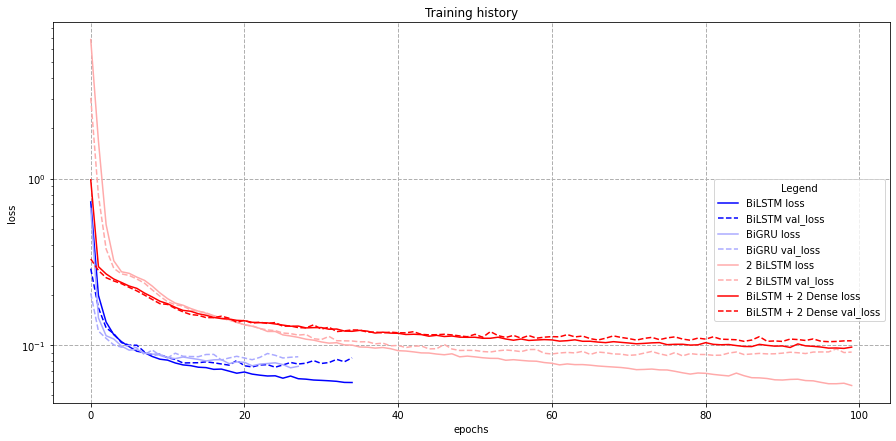

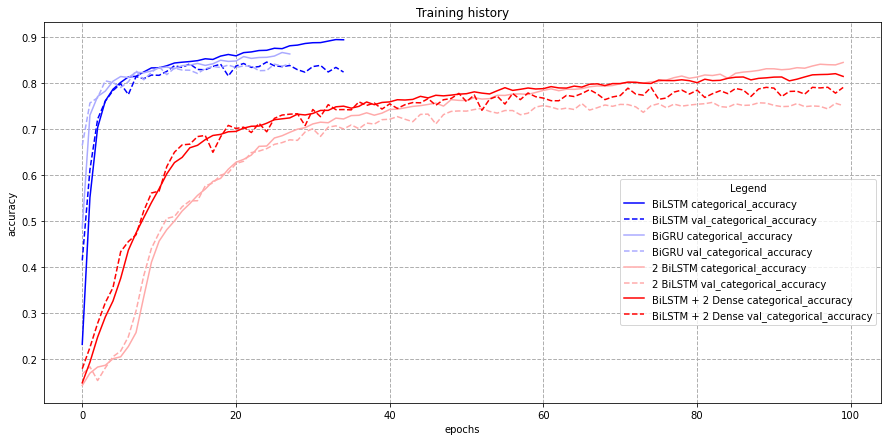

In [43]:
models_history = [history_bilstm, history_bigru, history_two_bilstm, history_bilstm_two_dense]
model_names = ["BiLSTM", "BiGRU", "2 BiLSTM", "BiLSTM + 2 Dense"]
plot_history(models_history, keys=['loss', 'val_loss'], model_names=model_names, labels=("epochs", "loss"), y_scale="log", figsize=(15,7),  cmap='bwr')
plot_history(models_history, keys=['categorical_accuracy', 'val_categorical_accuracy'], model_names=model_names, labels=("epochs", "accuracy"), figsize=(15,7),  cmap='bwr')

## 3. Evaluation

The two best models according to validation set are **BiLSTM** and **BiGRU**. Therefore the test set will be used with both of them.

The *classification report* is a summary of the metrics (precision, recall, f1_score) computed for each class and globally (micro, macro and weighted)

In [20]:
def get_flattened_comparison(model, X_test, y_test):

    raw_y_pred = model.predict(X_test)

    # converting indexes to labels
    y_true_label = target_vectorizer.inverse_transform(y_test)
    y_pred_label = target_vectorizer.inverse_transform_probabilities(raw_y_pred)

    y_true_flat = []
    y_pred_flat = []
    for document_predicted, document_true in zip(y_pred_label, y_true_label):
        for word_predicted, word_true in zip (document_predicted, document_true):
            y_pred_flat.append(word_predicted)
            y_true_flat.append(word_true)
    return y_true_flat, y_pred_flat

In [21]:
def show_classification_report(model, X_test, y_test, sorted_by=None, ascending=True):
  """
  Show classification report using only classes in names
  """
  y_true, y_pred = get_flattened_comparison(model, X_test, y_test)
  report =  classification_report(y_true, y_pred, output_dict=True, zero_division=0)
  
  # global performance
  keys = ['weighted avg', 'accuracy', 'macro avg']
  global_dict = {key: report[key] for key in keys}
  for key in keys:
    del report[key]

  df = pd.DataFrame.from_dict(report).transpose().round(2)
  if sorted_by:
    df.sort_values(by=sorted_by, ascending=ascending, inplace=True)
  print(df)

  print("\n\n")

  df_glob = pd.DataFrame.from_dict(global_dict).transpose().round(2)
  print(df_glob)

The *confusion matrix* can be very useful to understand main errors committed by the model

In [40]:
def evaluate_model(model, X_test, y_test, labels):
    """
    given a trained model and a test set returns the f-score and the confusion matrix
    taking into account only classes in labels
    """
    # show confusion matrix
    y_true_flat, y_pred_flat = get_flattened_comparison(model, X_test, y_test)
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,14))
    disp.plot(ax=ax)
    # f1 score
    print("F1 score:\n-------------------------------")
    print(sklearn.metrics.f1_score(y_true_flat, y_pred_flat, labels=labels, average='macro', zero_division=0))

It is not interesting evaluating *punctuation classes*, therefore they are not taken into account in the final evaluation

In [37]:
punctuation_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 17, 44]
classes = target_vectorizer.get_classes()
valid_labels = list(set(range(len(classes))) - set(punctuation_indexes))
meaningful_classes = classes[valid_labels]

BiLSTM and BiGRU model have been created using the best hyperparameter found by the tuner

### BiLSTM Model

F1 score:
-------------------------------
0.6245671834024557


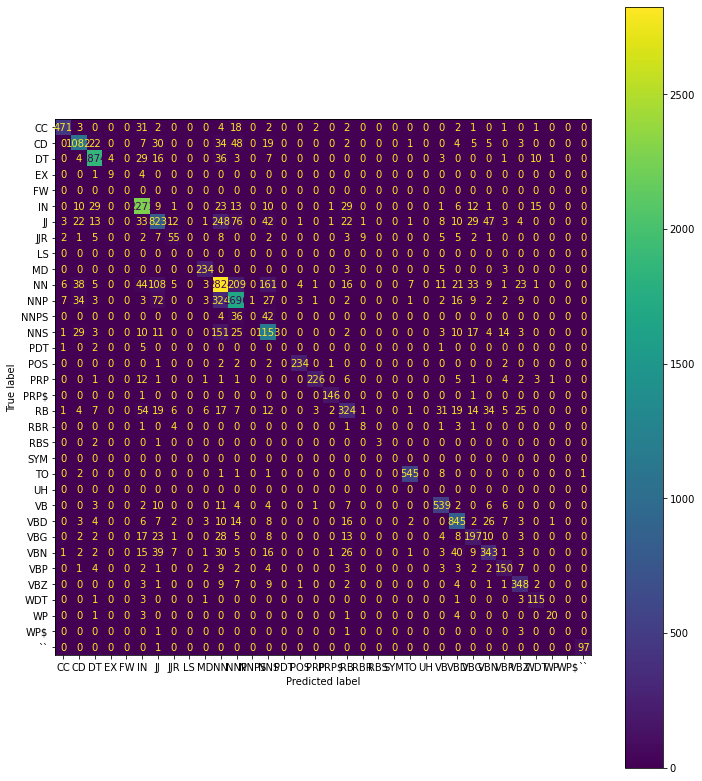

In [41]:
# confusion matrix and global f1 score
evaluate_model(model_bilstm, X_test, y_test, meaningful_classes)

In [25]:
# classification report using only meaningful classes
show_classification_report(model_bilstm, X_test, y_test, sorted_by=['f1-score'], ascending=False)

       precision  recall  f1-score  support
``          0.99    0.99      0.99     98.0
,           0.98    0.98      0.98   1171.0
''          0.96    0.99      0.97     95.0
PRP$        0.95    0.99      0.97    148.0
TO          0.97    0.97      0.97    560.0
.           0.94    0.99      0.97    907.0
$           0.95    0.97      0.96    270.0
POS         0.96    0.96      0.96    244.0
DT          0.94    0.94      0.94   1988.0
MD          0.91    0.96      0.93    245.0
:           0.96    0.86      0.91     84.0
CC          0.94    0.87      0.90    541.0
IN          0.87    0.92      0.90   2460.0
PRP         0.95    0.85      0.90    265.0
VB          0.86    0.90      0.88    602.0
VBD         0.83    0.88      0.86    964.0
CD          0.86    0.85      0.86   1271.0
WDT         0.76    0.93      0.84    124.0
VBZ         0.75    0.89      0.81    390.0
NNS         0.75    0.79      0.77   1452.0
NNP         0.78    0.76      0.77   2225.0
NN          0.74    0.79      0.

#### Result examples of BiLSTM model

In [32]:
i_test = 10  # change this to see the prediction for a different sentence
print("Original sentence: ", X_test_sentences[i_test])
print("Original POS tagging: ",target_vectorizer.inverse_transform([y_test[i_test]])[0])

raw_y_pred = model_bilstm.predict(np.array([X_test[i_test]]))

print("Predicted POS tagging: ",target_vectorizer.inverse_transform_probabilities(raw_y_pred)[0])

Original sentence:  ['but' 'courts' 'quickly' 'tumbled' 'down' 'a' 'slippery' 'slope' '.']
Original POS tagging:  ['CC' 'NNS' 'RB' 'VBD' 'IN' 'DT' 'JJ' 'NN' '.']
Predicted POS tagging:  ['IN' 'NNS' 'RB' 'VBD' 'RP' 'DT' 'JJ' 'NN' '.']


### BiGRU Model

F1 score:
-------------------------------
0.6062472113054655


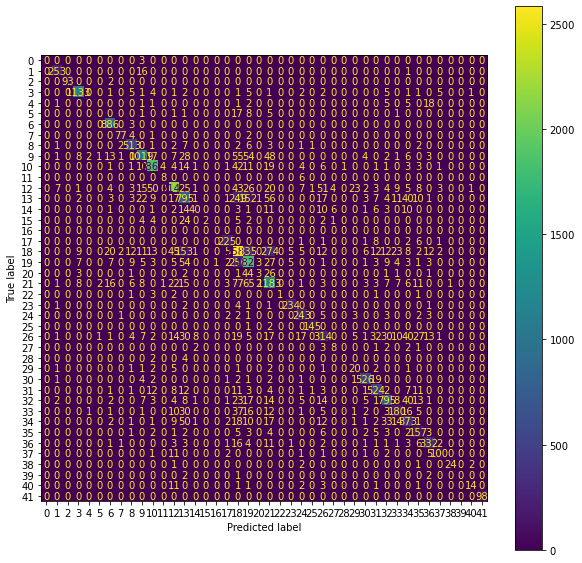

In [27]:
# confusion matrix and global f1 score
evaluate_model(model_bigru, X_test, y_test, meaningful_classes)

In [28]:
# classification report using only meaningful classes
show_classification_report(model_bigru, X_test, y_test, sorted_by=['f1-score'], ascending=False)

       precision  recall  f1-score  support
``          1.00    1.00      1.00     98.0
''          1.00    0.98      0.99     95.0
PRP$        0.98    0.98      0.98    148.0
,           0.97    0.97      0.97   1171.0
.           0.92    1.00      0.96    889.0
POS         0.96    0.96      0.96    244.0
$           0.94    0.94      0.94    270.0
TO          0.94    0.94      0.94    560.0
DT          0.93    0.94      0.93   1988.0
:           0.92    0.92      0.92     84.0
CC          0.90    0.95      0.92    541.0
MD          0.91    0.92      0.92    245.0
IN          0.92    0.87      0.90   2460.0
WP          0.96    0.80      0.87     30.0
PRP         0.81    0.92      0.86    265.0
CD          0.90    0.80      0.85   1270.0
VB          0.83    0.87      0.85    602.0
WDT         0.87    0.81      0.84    124.0
VBZ         0.83    0.85      0.84    390.0
VBD         0.86    0.82      0.84    964.0
NNP         0.70    0.82      0.76   2225.0
NNS         0.67    0.82      0.

#### Result examples of BiGRU model

In [30]:
i_test = 10  # change this to see the prediction for a different sentence
print("Original sentence: ", X_test_sentences[i_test])
print("Original POS tagging: ",target_vectorizer.inverse_transform([y_test[i_test]])[0])

raw_y_pred = model_bigru.predict(np.array([X_test[i_test]]))

print("Predicted POS tagging: ",target_vectorizer.inverse_transform_probabilities(raw_y_pred)[0])

Original sentence:  ['but' 'courts' 'quickly' 'tumbled' 'down' 'a' 'slippery' 'slope' '.']
Original POS tagging:  ['CC' 'NNS' 'RB' 'VBD' 'IN' 'DT' 'JJ' 'NN' '.']
Predicted POS tagging:  ['CC' 'NNS' 'RB' 'VBD' 'RP' 'DT' 'JJ' 'NN' '.']
